In [88]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

In [89]:
df = pd.read_csv("../data/SAHeart.csv", index_col=0)

df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


### 📐 Feature Units & Measurement Scales

Below is a breakdown of the dataset columns with associated **data types** and **units** (where applicable):

| Column      | Data Type | Units / Scale                    | Description |
|-------------|-----------|----------------------------------|-------------|
| `sbp`       | Numeric   | mmHg                             | Systolic Blood Pressure |
| `tobacco`   | Numeric   | kg (cumulative)                  | Lifetime tobacco consumption |
| `ldl`       | Numeric   | mmol/L                           | Low-density lipoprotein cholesterol |
| `adiposity` | Numeric   | Body-fat %                       | Measure of body fat |
| `famhist`   | Categorical | 'Present' or 'Absent'          | Family history of heart disease |
| `typea`     | Numeric   | Score (integer scale)            | Type A behavior assessment |
| `obesity`   | Numeric   | BMI                              | Obesity measure |
| `alcohol`   | Numeric   | Liters per year                  | Average alcohol intake |
| `age`       | Numeric   | Years                            | Age of subject |
| `chd`       | Binary    | 1 = CHD present, 0 = no CHD      | **Target** variable |


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 1 to 463
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 39.7+ KB


In [91]:
df.duplicated().sum()

np.int64(0)

In [92]:
df.describe(include='all')

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462,462.000000,462.000000,462.000000,462.000000,462.000000
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,Absent,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,270,NaN,NaN,NaN,NaN,NaN
mean,138.326840,3.635649,4.740325,25.406732,NaN,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,NaN,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,NaN,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,NaN,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,NaN,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,NaN,60.000000,28.497500,23.892500,55.000000,1.000000


### Summary Statistics – Key Insights

The `.describe()` method provided valuable numerical context for each feature. Here's what we observed:

#### 💉 Cardiovascular Risk Factors:
- **sbp (Systolic BP)**:  
  - Average: **138 mmHg** — elevated; many individuals may be hypertensive.  
  - Range: **101–218**, indicating presence of high blood pressure.
- **ldl (Cholesterol)**:  
  - Mean: **4.74 mmol/L** — slightly elevated above healthy levels (<3.0 is ideal).  
  - Max: **15.33 mmol/L**, suggesting extreme cases.
- **adiposity (Body Fat %) & obesity (BMI proxy)**:  
  - Mean adiposity: **26.1%**  
  - Mean obesity score: **26.0**, with some individuals exceeding **46**, indicating obesity.
- **age**:  
  - Range: **15–64**, with a mean of **43 years** — skewed toward middle-aged adults.
- **tobacco**:  
  - Avg usage: **3.64 kg/year**, but max is **31.2 kg**, showing some heavy smokers.

#### Lifestyle & Behavior:
- **alcohol**:  
  - Wide range: from **0 to 147 L/year** — highly skewed.  
  - Median is much lower (**7.5 L**), but outliers suggest problematic drinking in a subset.
- **typea (Behavioral Score)**:  
  - Mean: **53**, max: **78** — potential stress indicator; might correlate with CHD.

#### Family History:
- `famhist` was split into:  
  - **Absent**: 270  
  - **Present**: 192  
  - Label encoded for analysis (`0` and `1`)

#### Target Variable – `chd`:
- Binary: `0` (no disease), `1` (has CHD)  
- Mean: **0.346** → ~**35%** of individuals have CHD

In [93]:
df['famhist'].value_counts()

famhist
Absent     270
Present    192
Name: count, dtype: int64

In [94]:
# Encode famhist: Absent = 0, Present = 1
df['famhist'] = df['famhist'].map({'Absent': 0, 'Present': 1})

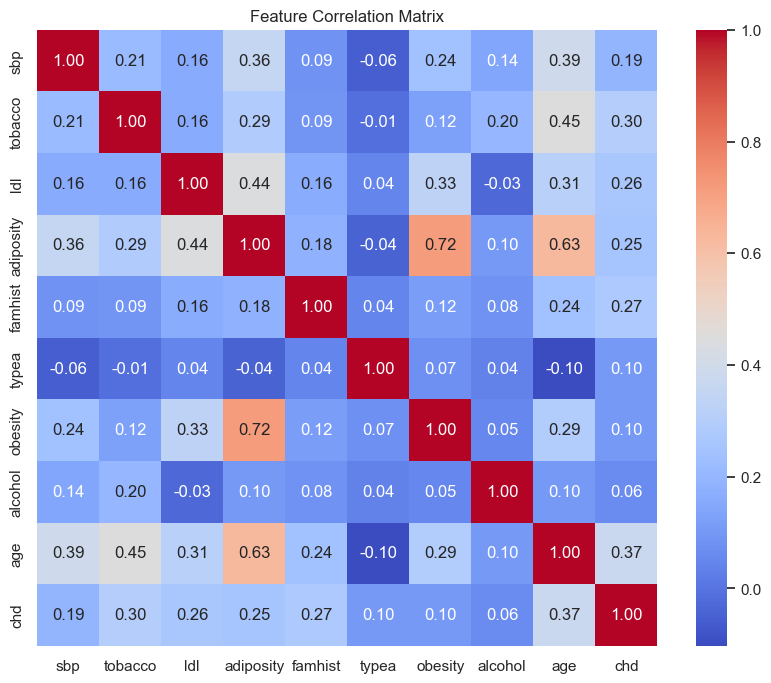

In [95]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### EDA Phase 1 – Data Exploration & Cleaning

#### Setup & Imports
- Imported libraries:
  - `pandas`, `numpy` for data wrangling
  - `matplotlib`, `seaborn` for plotting
  - `sklearn` for preprocessing and modeling

#### Data Loading
- Loaded `SAHeart.csv` using `pandas.read_csv()`
- Inspected data with `.head()`, `.info()`

#### Data Quality Checks
- No missing values (`.info()` confirms 462 non-null per column)
- No duplicate rows (`df.duplicated().sum()` = 0)

---

### Exploratory Data Analysis (EDA)

#### Categorical Variable – `famhist`
- Family history of heart disease (`Absent` or `Present`)
- Value counts:
  - `Absent`: 270  
  - `Present`: 192
- Label encoded to numeric:  
  - `Absent = 0`, `Present = 1`

#### Target Variable – `chd`
- Binary: `0` = no heart disease, `1` = has CHD
- Class distribution:
  - `0` → ~65% of patients
  - `1` → ~35% of patients

---

### 🔍 Correlation Analysis

#### Correlation Heatmap
- Used `df.corr(numeric_only=True)` with `seaborn.heatmap()`
- Visualized linear relationships between features and target
- Interpretation:
  - +1 = strong positive correlation
  - –1 = strong negative correlation
  - 0 = no correlation
- Notable correlations with `chd`:
  - `age`: **+0.37**
  - `tobacco`: **+0.30**
  - `ldl`: **+0.26**
  - `famhist`: **+0.27**
  - `adiposity`: **+0.25**

---

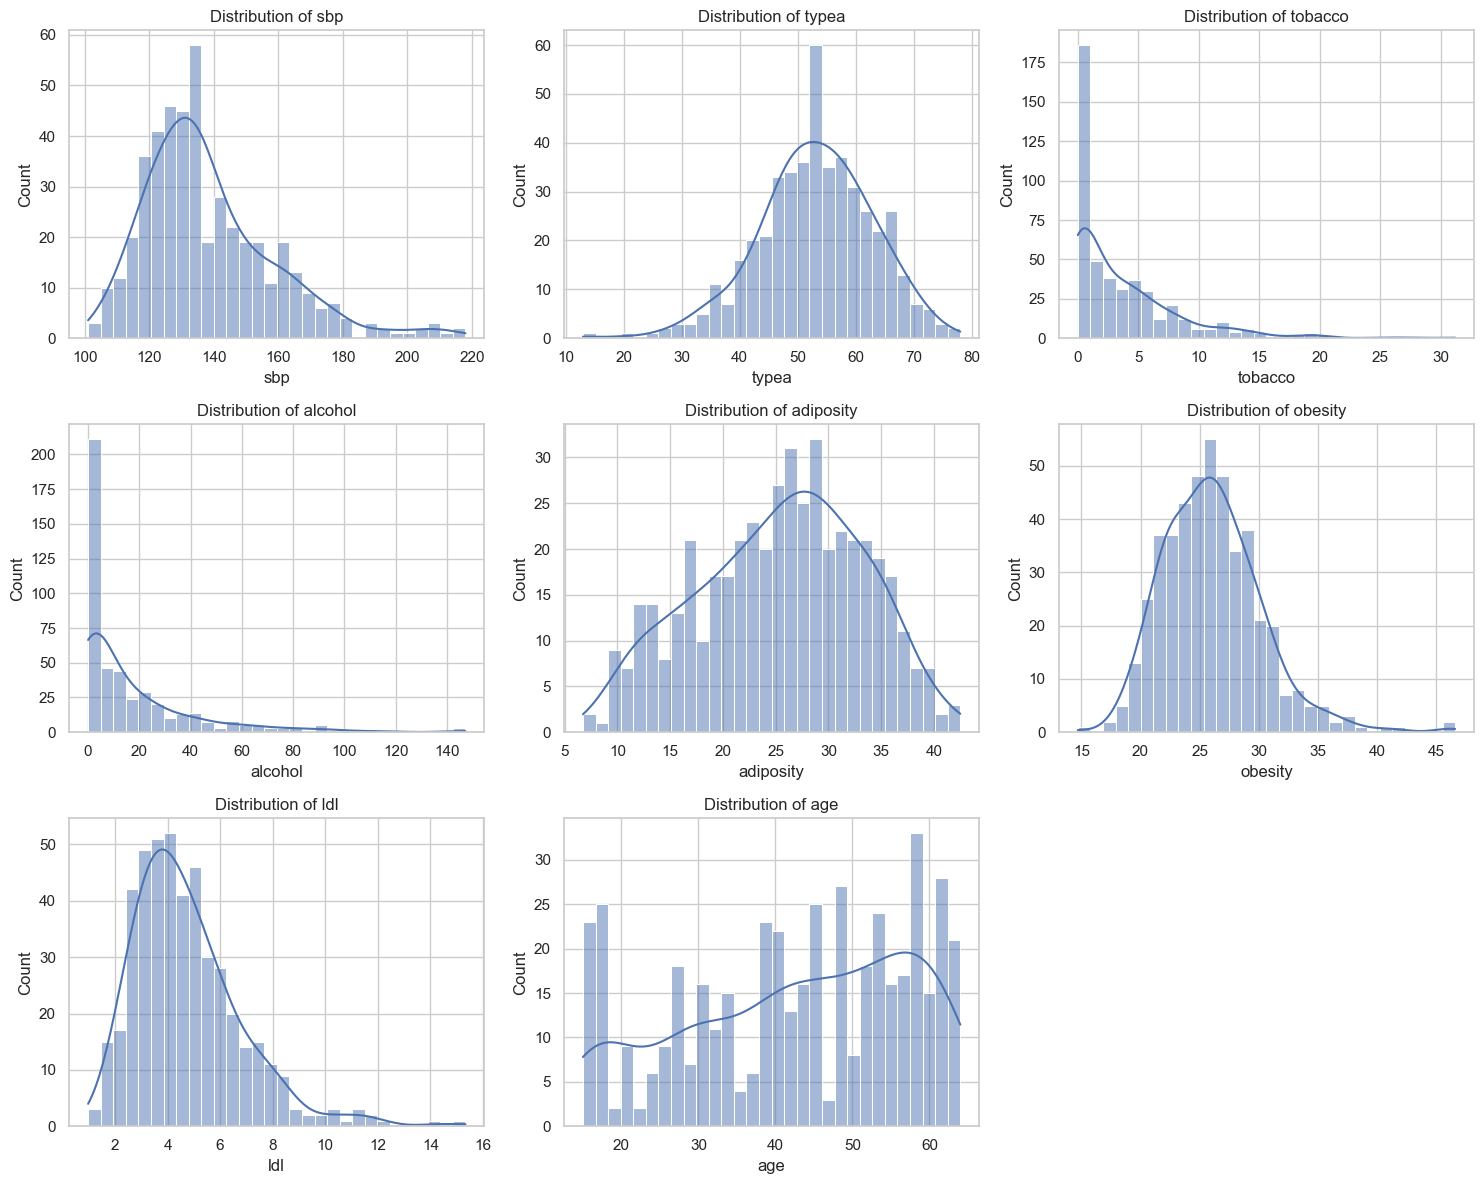

In [96]:
numerical_cols = ['sbp', 'typea', 'tobacco', 'alcohol', 'adiposity', 'obesity', 'ldl', 'age']

plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


### 📈 EDA Phase 2 – Univariate Analysis (Numerical Features)

We explored the distribution of all numerical features using histograms + KDE curves:

### Key Insights:

- **`sbp` (Systolic BP)**: Right-skewed — most patients fall between 120–150 mmHg, with a few high outliers.
- **`tobacco`**: Strong right skew — most individuals have low usage (under 5 kg/year), but a few heavy users extend the tail.
- **`ldl` (Bad cholesterol)**: Slight right skew — concentrated around 3–6 mmol/L with outliers up to ~15.
- **`adiposity`**: Fairly symmetric bell-shaped distribution centered around 25–30, with mild tails.
- **`typea` (Behavior score)**: Looks roughly normal — centered around 50, slight skew right.
- **`obesity`**: Also roughly normal — concentrated between 24–30%.
- **`alcohol`**: Strong right skew — most drink very little, but outliers go above 100 units.
- **`age`**: Bimodal-ish and somewhat jagged — more patients in their 40s–60s, sparse under 30.

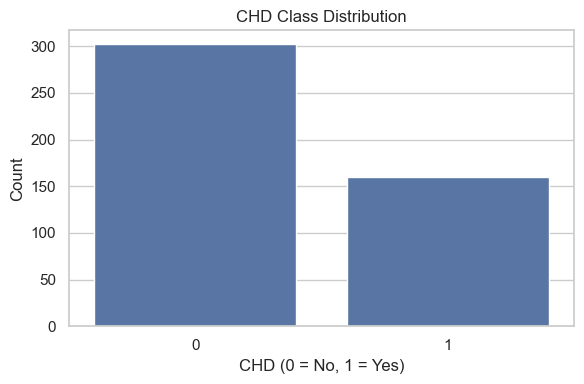

CHD Class Counts:
chd
0    302
1    160
Name: count, dtype: int64


In [97]:
sns.set(style="whitegrid")

# CHD Class Distribution Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='chd', data=df)
plt.title('CHD Class Distribution')
plt.xlabel('CHD (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Display exact class distribution counts
print("CHD Class Counts:")
print(df['chd'].value_counts())

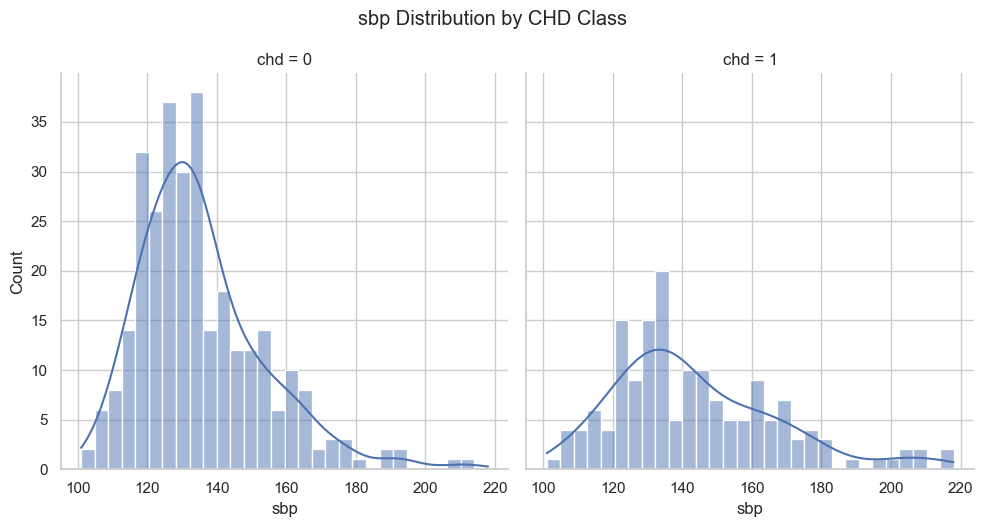

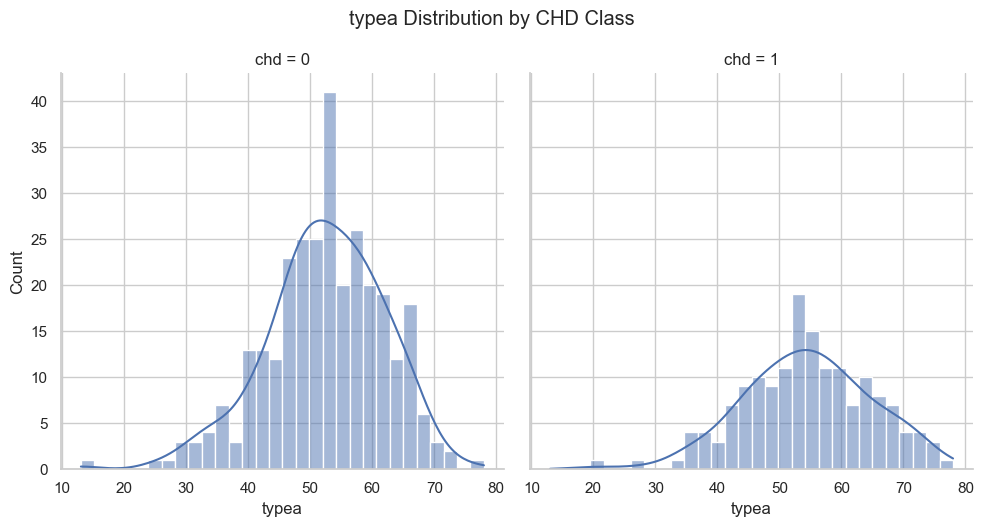

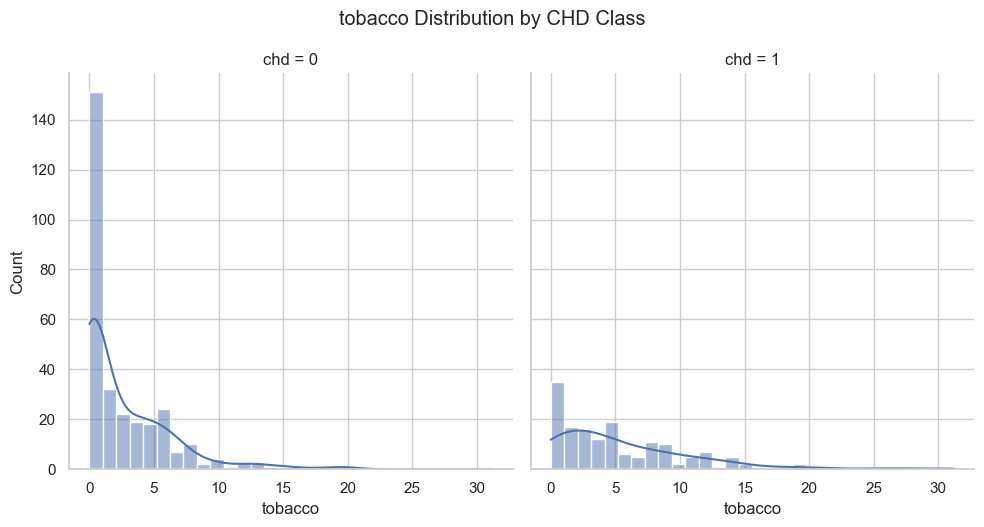

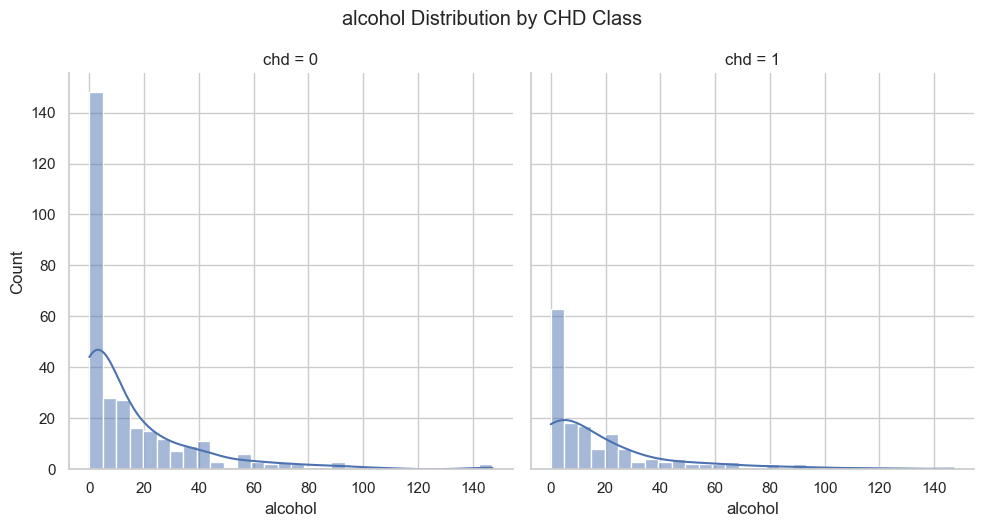

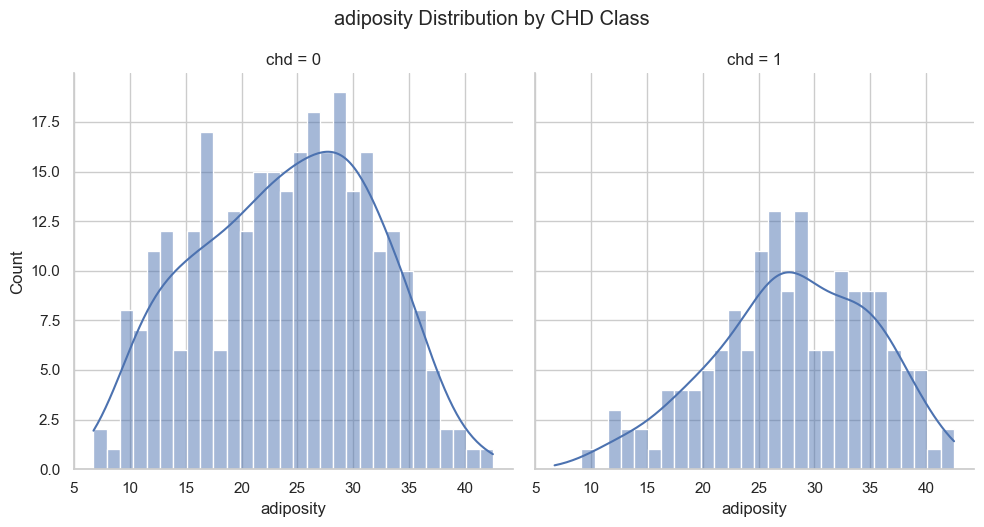

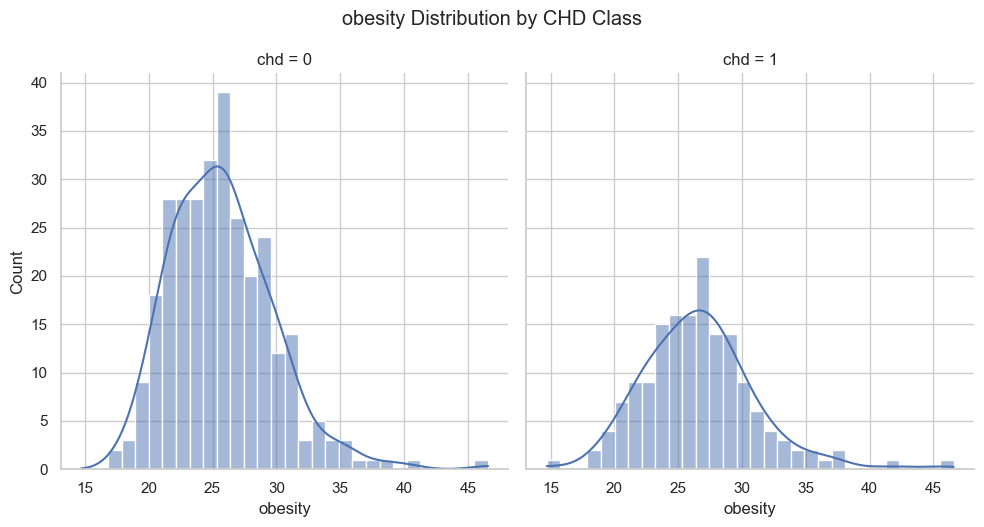

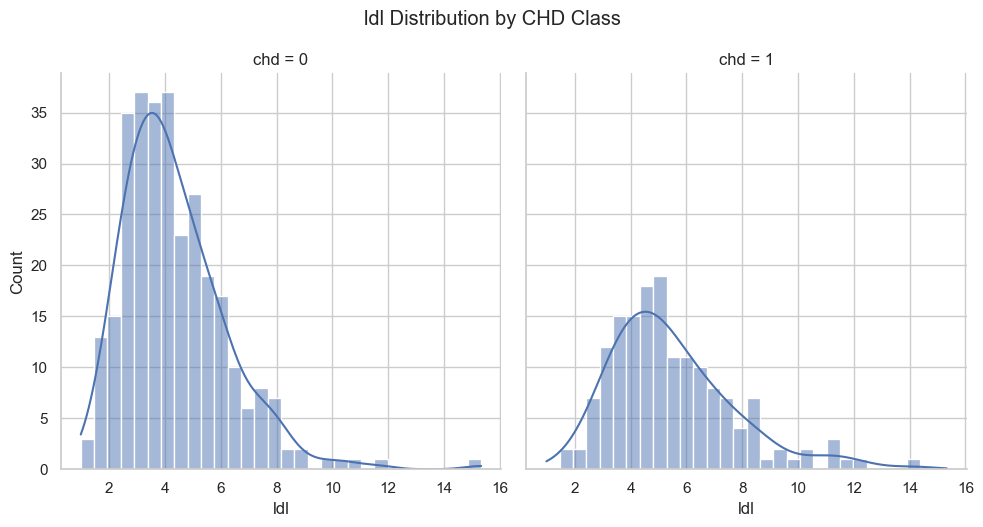

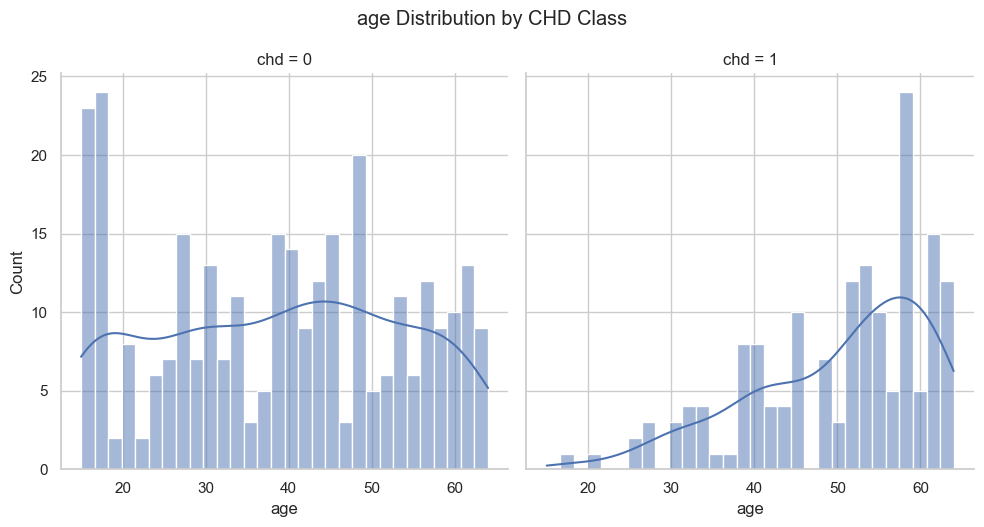

In [98]:
numerical_cols = ['sbp', 'typea', 'tobacco', 'alcohol', 'adiposity', 'obesity', 'ldl', 'age']

for col in numerical_cols:
    sns.displot(data=df, x=col, col='chd', kde=True, bins=30)
    plt.suptitle(f'{col} Distribution by CHD Class', y=1.05)
    plt.show()

### 📈 Feature Distributions by CHD Class (KDE Histograms)

To better understand how key features differ between individuals with and without coronary heart disease (CHD), we plotted kernel density estimate (KDE) histograms for each variable, split by `chd` status (0 = No, 1 = Yes). This format makes it easier to visually compare distributions than boxplots.

#### 🔍 Observations:

- **sbp (Systolic Blood Pressure):**
  - CHD patients tend to have higher blood pressure.
  - Clear shift in distribution toward higher values for `chd = 1`.

- **tobacco (Cumulative Tobacco Use in kg):**
  - CHD-positive group shows more heavy smokers.
  - Distribution is right-skewed, with a longer tail for `chd = 1`.

- **ldl (Low-Density Lipoprotein):**
  - Higher LDL levels are associated with CHD.
  - Mean shifts right for `chd = 1`.

- **adiposity (Body Fat % estimate):**
  - Distribution is noticeably shifted higher in the CHD group.
  - Suggests increased adiposity may be a risk factor.

- **typea (Behavior Score - Higher = More Type A):**
  - Slightly more right-skewed in CHD group.
  - Mean values are slightly higher for those with CHD.

- **obesity (BMI-based metric):**
  - Distributions are similar, but CHD patients show a slightly more symmetric and centered distribution.
  - The tail is longer for non-CHD group.

- **alcohol (Weekly Alcohol Consumption in liters):**
  - Highly skewed right in both groups.
  - No strong visual distinction between CHD and non-CHD groups.

- **age:**
  - Most visually distinct.
  - CHD group is notably older on average.
  - Sharp rightward shift in distribution for `chd = 1`.

#### Takeaway:
Age, systolic blood pressure, tobacco use, LDL, and adiposity show the clearest differences between CHD groups, making them strong candidates for predictive modeling. Visualizing the full distribution helped uncover nuances not easily visible in boxplots.

## Modeling Portion

In [99]:
# Features and target
X = df.drop(columns='chd')
y = df['chd']

In [100]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [101]:
# Initialize scaler
scaler = StandardScaler()

# Fit on train, transform train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [102]:
# Initialize Logistic Regression
log_reg = LogisticRegression()

# Initialize Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)

# Initialize Random Forest
forest_clf = RandomForestClassifier(random_state=42)

In [103]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model", cmap='Blues'):
    # Fit
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Print
    print(f"\n{model_name} Metrics")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"ROC AUC Score: {roc_auc:.3f}")

    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap=cmap)
    plt.title(f"{model_name} – Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



Logistic Regression Metrics
Accuracy: 0.742
Precision: 0.625
Recall: 0.625
F1 Score: 0.625
ROC AUC Score: 0.818


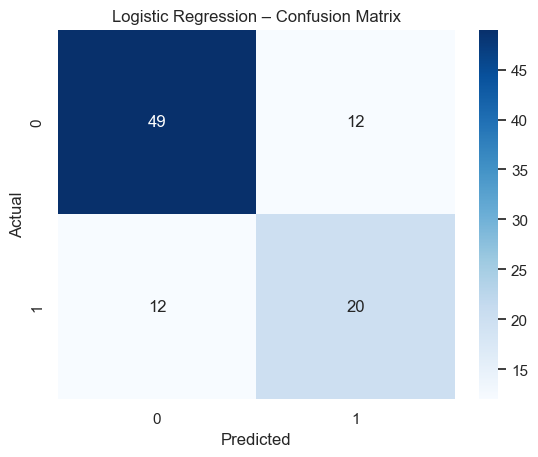


Decision Tree Metrics
Accuracy: 0.548
Precision: 0.396
Recall: 0.594
F1 Score: 0.475
ROC AUC Score: 0.559


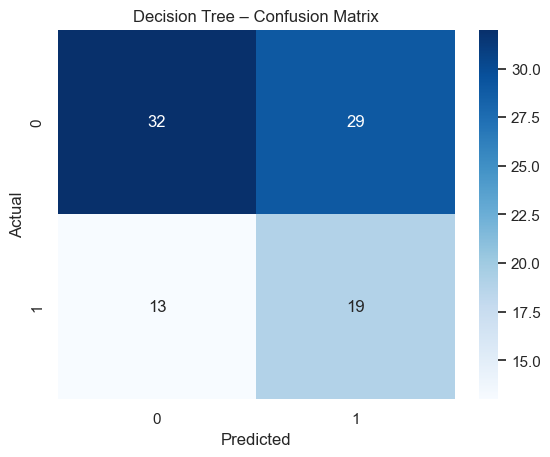


Random Forest Metrics
Accuracy: 0.677
Precision: 0.531
Recall: 0.531
F1 Score: 0.531
ROC AUC Score: 0.715


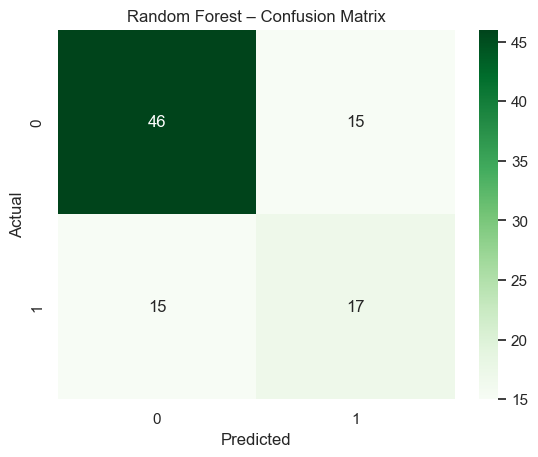

In [104]:
evaluate_model(log_reg, X_train_scaled, y_train, X_test_scaled, y_test, model_name="Logistic Regression")

evaluate_model(tree_clf, X_train_scaled, y_train, X_test_scaled, y_test, model_name="Decision Tree", cmap='Blues')

evaluate_model(forest_clf, X_train_scaled, y_train, X_test_scaled, y_test, model_name="Random Forest", cmap='Greens')

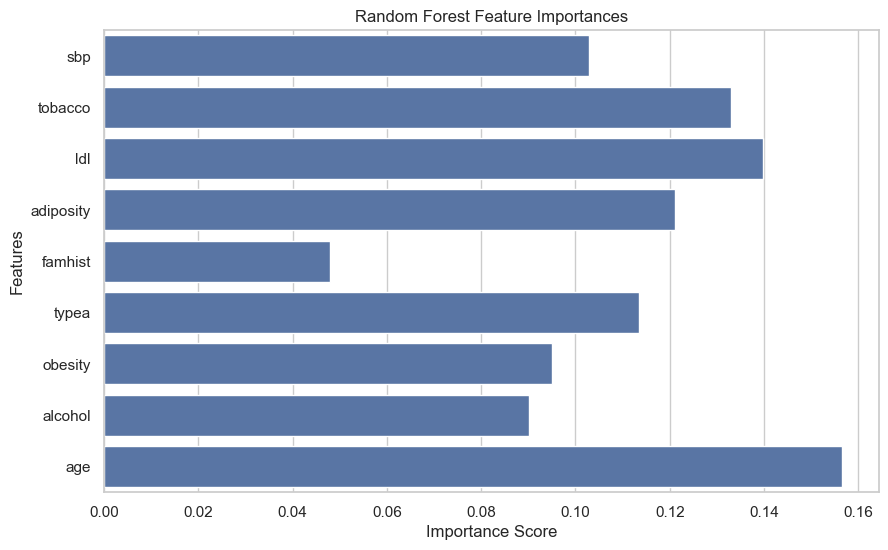

In [105]:
# Feature importance from Random Forest
importances = forest_clf.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

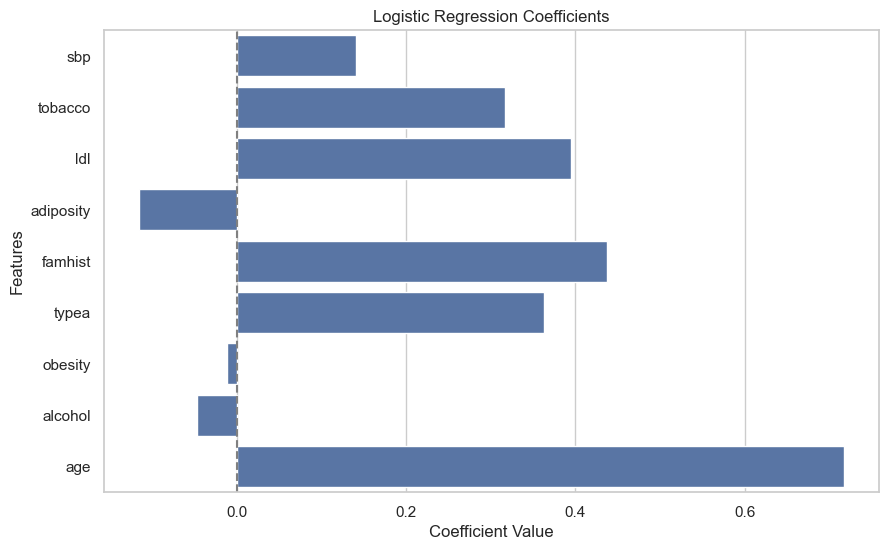

In [106]:
# Logistic Regression Feature Coefficients
coef = log_reg.coef_[0]
features = X.columns

# Create a barplot of coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=coef, y=features)
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.axvline(0, color='gray', linestyle='--')  # line at zero
plt.show()

## Modeling Summary

We trained three classification models to predict coronary heart disease (CHD):

---

### Logistic Regression
- Accuracy: **0.74**
- Precision: **0.63**
- Recall: **0.63**
- F1 Score: **0.63**
- ROC AUC: **0.82** ✅ *Best ROC AUC*

**Notes:**
- Age had the strongest positive influence.
- Family history, LDL, and Type A behavior were also positive predictors.
- Logistic Regression is interpretable and performed best in ROC AUC.

---

### Decision Tree
- Accuracy: **0.54**
- Precision: **0.40**
- Recall: **0.59**
- F1 Score: **0.48**
- ROC AUC: **0.56**

**Notes:**
- Struggled with accuracy and precision.
- Likely overfitting — needs pruning or tuning to improve.

---

### Random Forest
- Accuracy: **0.68**
- Precision: **0.53**
- Recall: **0.53**
- F1 Score: **0.53**
- ROC AUC: **0.72**

**Top Features:**
- Age, LDL, Tobacco use, Adiposity, and Type A behavior.

**Notes:**
- More balanced than Decision Tree.
- Handles non-linear patterns well, but less interpretable.

---

### Conclusion:
- Logistic Regression had the highest **ROC AUC** and is best suited when interpretability is key.
- Random Forest is a solid backup with good balance across metrics.
- Decision Tree underperformed without tuning.

### Final Thoughts

This analysis explored predictive modeling for coronary heart disease (CHD) using clinical and behavioral data.

---

#### Key Takeaways:

- **Age**  
  Risk of CHD increases naturally with each passing year. This serves as a reminder to cherish every day and prioritize both physical and **mental health**.

- **Type A Behavior**  
  More reactive, high-stress individuals may be at increased risk. Learning to manage stress, slow down, and cultivate emotional balance can offer real cardiovascular benefits.

- **Family History**  
  A significant predictor of CHD. Take time to understand your family’s medical background — it could inform preventative decisions and screenings.

- **Lifestyle Modifications**  
  Classic advice remains powerful:
  - Reduce **body fat** and manage **adiposity**
  - Improve **LDL cholesterol** through diet and activity
  - Avoid tobacco
  - Limit alcohol consumption

---

**In summary:**  
Small, consistent lifestyle choices can meaningfully reduce the risk of CHD.  
The data supports it — and now, so do you.